In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join as os_join
import pandas as pd

from source.model import BeamModel
import source.postprocess as postprocess
from source.utilities import utilities as utils
from source.Querschnitte import nEck, KreisRing
import source.utilities.global_definitions as GD
from source.utilities import holz


2D Euler-Bernoulli Balken:

x-Achse: Längsrichtung
y-Achse: Querrichtung
gamma: Verdrehung
Biegung um z-Achse
(keine Torsion)

![Balken](Beschreibungen/Balken_cosy_klein.png)

# Definieren der (Grund) Geometrischen sowie der Material Parameter

Abschnittsweise veränderliche Querschnittswerte werden nach erstellen der Querschnitte nEck und KreisRing ergänzt: 'defined on intervals'

Derzeit macht es vieles einfacher wenn die Anzahl der elemente des Balken 'n_elements' gleich der Ebenen anzahl des Modells ist. 


In [2]:
parameters = {
               'dimension': '2D',
                'n_elements': 13,
                'lx_total_beam': 110,
                'material_density': 904,# 500,#42, #für dynamische Berechnung äquivalenter Wert
                'total_mass_tower': 668390,# aus RFEM
                'nacelle_mass': 287920.5,# RFEM: 267910,# IEA37: 191000, # Gondel Masse in kg
                'vorspannkraft':12*2.5E+06, # N
                'imperfektion':0.005, # m/m 
                'E_Modul': 12000E+06,# N/m²
                'nu': 0.1, # querdehnung
                'damping_coeff': 0.025,
                'nodes_per_elem': 2,
                'cross_section_area': 12*12, #Not used if intervals
                'Iz': 51.0,# Not used if defined on intervals
                'dofs_of_bc':[0,1,2], # Einspannung
                'type_of_bc':'clamped',#'clamped',# or 'spring'
                'spring_stiffness':[1E+13,2E+13], # Federsteifigkeit am Boden in u und gamma richtung
                'dynamic_load_file': os_join(*["inputs","forces","dynamic_force_11_nodes.npy"]),
                'eigen_freqs_target':[0.133,0.79,3.0], 
                'defined_on_intervals':[] # kann gefüllt werden mit einer pickle datei 
            }
n_nodes = parameters['n_elements']+1

werkstoff_parameter = holz.charakteristische_werte['BSP_RFEM']
parameters['material_density'] = werkstoff_parameter['rhok']
parameters['E_Modul'] = werkstoff_parameter['E0mean']

nachweis_parameter = holz.HOLZBAU

# Ergebnisse in einem DataFrame speichern - reihe = Höhe; Spalte = Ergebniss
# TODO: den Spalten namen mehrere Level geben Name, einheit, Querschnittstyp z.B. 
# https://stackoverflow.com/questions/32370402/giving-a-column-multiple-indexes-headers 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# results_df = pd.DataFrame()
df_results_header = [[],[], []] # 1. Liste = 1. Level usw...
grund_parameter_df = pd.DataFrame() # grundlegende parameter die untersucht werden

results_excel = os_join(*['output','Berechnungs_Ergebnisse.xlsx'])

# Querschnittsdefinition

- mit create_cross_sections.py können Querschnitte (nEck und KreisRing) erstellt werden und als dictonary in einer pickle Datei gespeichert. (Gedacht für den Systematischen Vergleich mehrerer QS)
- Querschnitte müssen immer über Querschnitt.export_to_dict_pkl() gespeichert werden 
- diese müssen geladen werden (eindeutige Identifikation über den Namen der Datei) und den aktuellen parametern angehängt werden (wird diese Funktion verwendet werden nötige Variablen wie die totale länge automatisch angepasst)

Sollen mehrere Querschnitte untersucht werden ist gedacht eine Liste an Dateien mit den unterschiedlichen Querschnitten zu erstellen.

In [3]:
# um zwischen den Alternativen zu Wählen
querschnitts_dateien_laden = True

#### Alternative 1: Querschnitte Laden aus Dateien erstellt mit "create_cross_sections.py"

In [4]:
if querschnitts_dateien_laden:
    d_unten = 12
    ecken = [12,10,8] #
    höhen = [110,130,140,150,160]#]
    t_längslagen = 40 #cm 48 56
    t_querlagen = 8 #cm
    holzgüte = 'C24'
    
    querschnitte = []#, 'Kreisring_d12.pkl']#'8Eck.pkl','10Eck.pkl', 
    for höhe in höhen:
        filename = 'Ring_' + str(höhe) + '_du' + str(d_unten) + '_' + holzgüte + '_tX' + str(t_längslagen) + '_tY' +str(t_querlagen)+ '.pkl'
        querschnitt_object = utils.load_object_from_pkl(os_join(*['inputs', 'geometry', 'objekte', filename]))
        querschnitte.append(querschnitt_object)
        for n_ecken in ecken:
            filename = str(n_ecken) + 'Eck_' + 'h'+ str(höhe)  + '_du' + str(d_unten) + '_' + holzgüte + '_tX' + str(t_längslagen) + '_tY' +str(t_querlagen)+ '.pkl'
            querschnitt_object = utils.load_object_from_pkl(os_join(*['inputs', 'geometry', 'objekte', filename]))
            querschnitte.append(querschnitt_object)

    # erste Spalte im Dataframe sollten die höhen sein 
    # results_df['z_coords_h' + str(höhe)] = querschnitt_object.section_absolute_heights     

#### Alternative 2: Direkt definieren eines / mehrerer Querschnitte

In [5]:
if not querschnitts_dateien_laden:
        querschnitte = []
        d_oben = 3.4 # durchmesser am Kopf immer so
        d_unten = 12 
        n_ebenen = 14
        if n_ebenen != n_nodes:
                print ('WARNING: besser gleich viele Ebenen wie Knoten für die Berechnung')
        höhen_parameter = {}
        d_achse = np.linspace(12, 3.4, n_ebenen)
        t_wand = 0.4
        einheiten_input = {'Kraft':'N', 'Moment':'Nm', 'Festigkeit':'N/mm²', 'Länge':'m'}

        lagen_aufbau = [{'ortho':'X','ti':0.16},
                        {'ortho':'Y','ti':0.04},
                        {'ortho':'X','ti':0.08},
                        {'ortho':'Y','ti':0.04},
                        {'ortho':'X','ti':0.16}]

        m2cm = utils.unit_conversion('m','cm')
        t_laengslagen = sum([lage['ti'] for lage in lagen_aufbau if lage['ortho'] == 'X'])
        t_querlagen = sum([lage['ti'] for lage in lagen_aufbau if lage['ortho'] == 'Y'])
        t = (t_laengslagen + t_querlagen) * m2cm
        grund_parameter_df['t [cm]'] = [t] *2

        höhe = parameters['lx_total_beam']
        höhen_parameter['absolute_höhen'] = np.linspace(0, höhe, n_ebenen)
        höhen_parameter['hfract'] = höhen_parameter['absolute_höhen']/höhen_parameter['absolute_höhen'][-1]

        kreis_ring = KreisRing(d_achse, cd = 1.1, lagen_aufbau=lagen_aufbau,
                                holz_parameter = werkstoff_parameter, 
                                nachweis_parameter = nachweis_parameter,
                                hoehen_parameter= höhen_parameter, einheiten=einheiten_input)

        n_ecken = 12                     
        current_nEck = nEck(n_ecken, d_achse, cd = 1.5, lagen_aufbau=lagen_aufbau, 
                                holz_parameter = werkstoff_parameter, 
                                nachweis_parameter = nachweis_parameter,
                                hoehen_parameter= höhen_parameter, einheiten=einheiten_input)


        querschnitte =[kreis_ring, current_nEck]

        # results_df['z_coords'] = höhen_parameter['absolute_höhen']


Den Dataframe für die Ergebnisse der zu untersuchenden Querschnitte richtig vorbereiten 

In [6]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

for qs in querschnitte:
    if qs.max_height not in df_results_header[0]:
        df_results_header[0].append(qs.max_height)
    if qs.name not in df_results_header[1]:
        df_results_header[1].append(qs.name)

    # Berechnungsergebnisse - dritte Ebene:
    if not df_results_header[2]: 
        df_results_header[2].append('Höhe [' + qs.einheiten['Länge'] + ']') 
        df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_zug [' + qs.einheiten['Normalspannung'] + ']') 
        df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_druck [' + qs.einheiten['Normalspannung'] + ']') 
        df_results_header[2].append('Ausnutzung druck') 

        df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_N [' + qs.einheiten['Normalspannung'] + ']') 
        df_results_header[2].append(GD.GREEK_UNICODE['sigma'] + '_M [' + qs.einheiten['Normalspannung'] + ']') 

df_results_header = pd.MultiIndex.from_product(df_results_header, names=['Nabenhöhe', 'Querschnitt', 'Ergebnisse'])
results_df = pd.DataFrame(columns=df_results_header)

# Äußere Belastung 


- Windkraft F_w über die Höhe wird nach DIN berechnet (cscd vernachlässigt Bert = 1.01, DIBt 9.3.2: muss im Parkzustand berücksichtigt werden im Analgenbetrieb nicht).

![Formel](Beschreibungen/Fw_formel.PNG)
    
- Angabe eines eigenen cd / cf Werts (drag coefficient bzw. Kraftbeiwert)

- Kopflasten aus IEA37 Min/Max Tabellen

- Schiefstellung 5 mm/m (DIBt Windenergieanlagen Richtlinie 2012 Kapitel 7.4)

### Einwirkungsdauer

- Einteilung der Lasten nach dauer 'kurz' und 'ständig' (durch keys in dictonaries)

### Dateinamens Konvention

Die Lasten müssen in einer .npy datei gespeichert werden um vom beam gelesen werden zu können. Für die Dateinamen wird folgende bezeichnugn festgelegt:

- K-IEA@maxFx_ = Kopflasten + Quelle der min max tabelle + angabe aus welcher reihe der min max tabelle 

- W-v17cd1.5_ = Windlast + Bsiswindgeschwindigeit + cd Wert

- D-kurz = Dauer der Einwirkung


Windbelastung aus:
    vb: 17
    terrain: II
    gamma_q: 1.35


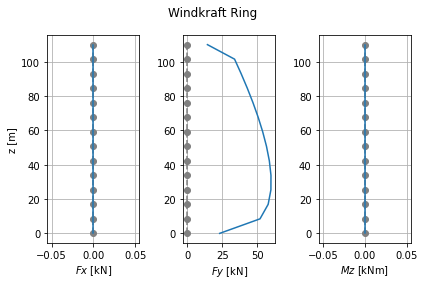

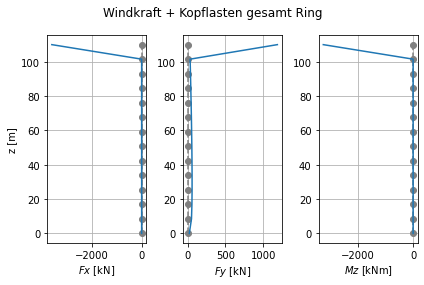

In [7]:
kopf_lasten_IEA = {'Fx':1.17E+06,'Fy':4.80E+04, 'Fz':-3.64E+06, 'Mx':5.98E+06, 'My':3.24E+06, 'Mz':2.31E+06}
kopf_lasten_IEA_0 = {'Fx':0,'Fy':0, 'Fz':-0, 'Mx':0, 'My':0, 'Mz':0} # als platzhalter
kopf_lasten_beam = utils.convert_coordinate_system(kopf_lasten_IEA) # Koordinaten definiton abweichend und einteilung in Einwirkungsdauer
kopf_lasten_beam_0 = utils.convert_coordinate_system(kopf_lasten_IEA_0) # Koordinaten definiton abweichend
lasten_dict_base = {'Fx':np.zeros(n_nodes), 'Fy':np.zeros(n_nodes), 'Mz':np.zeros(n_nodes)}

einwirkungsdauer = ['ständig','kurz', 'egal']
gamma_q = 1.35

import source.DIN_Windlasten as wind_DIN

basis_windgeschwindigkeit = 17
terrain_kategorie = 'II'
print ('Windbelastung aus:')
print ('    vb:', basis_windgeschwindigkeit)
print ('    terrain:', terrain_kategorie)
print ('    gamma_q:', gamma_q)
#wind_DIN.plot_DIN_all(basis_windgeschwindigkeit, categories=[terrain_kategorie])

wind_kraft_z = {}
lasten_files, lasten_dicts = {}, {}
grund_parameter_df['Querschnitt'] = [q.name for q in querschnitte]
grund_parameter_df['t [cm]'] = [q.wand_stärke for q in querschnitte]
grund_parameter_df['Nabenhöhe [m]'] = [q.section_absolute_heights[-1] for q in querschnitte]
grund_parameter_df['cd'] = [q.cd for q in querschnitte]

for querschnitt in querschnitte:
    # Infromationen vom QS Objekt holen
    QS_label = querschnitt.name
    cd = querschnitt.cd
    höhen_z = querschnitt.section_absolute_heights
    nabenhöhe = querschnitt.max_height
    d_achse = querschnitt.d_achse 

    # Ergebniss Daten vorbereiten
    if QS_label not in lasten_files:
        lasten_files[QS_label] = {}
        lasten_dicts[QS_label] = {}

    if nabenhöhe not in lasten_files[QS_label]:
        lasten_files[QS_label][nabenhöhe] = {}
        lasten_dicts[QS_label][nabenhöhe] = {}

    # Lastberechnung für den spezifischen QS
    wind_kraft_z, z_coords = wind_DIN.wind_kraft(vb=basis_windgeschwindigkeit, category=terrain_kategorie, height=höhen_z, cd = cd, Aref=d_achse)

    knoten_wind_kraft_z = utils.linien_last_to_knoten_last(wind_kraft_z, höhen_z, gamma_q = 1.35)
    #postprocess.plot_along_height(knoten_wind_kraft_z, z_coords, label='wind_kraft [N]')

    lasten_dict_nur_wind = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam_0['egal'])
    lasten_dicts[QS_label][nabenhöhe]['egal']  = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam['egal']) #unabhängig von der Einwirkungsdauer
    # _____Sortiert nach Einwirkungsdauer __________________________
    lasten_dicts[QS_label][nabenhöhe]['kurz'] = utils.update_lasten_dict(lasten_dict_base, knoten_wind_kraft_z, kopf_lasten_beam['kurz'])
    lasten_dicts[QS_label][nabenhöhe]['ständig']  = utils.update_lasten_dict(lasten_dict_base, wind_kraft = None, kopflasten = kopf_lasten_beam['ständig'])

    # ____________ LASTEN DATEI GENERIEREN ___________________________
    for dauer in einwirkungsdauer:
        filename = 'K-IEA@maxFx_' + 'W-v' +str(basis_windgeschwindigkeit) + 'cd' + str(cd) + '_D-' + dauer
        lasten_files[QS_label][nabenhöhe][dauer] = utils.generate_lasten_file(n_nodes, lasten_dicts[QS_label][nabenhöhe][dauer], file_base_name=filename)

    if QS_label == 'Ring' and nabenhöhe == 110:
        postprocess.plot_dict_subplots(lasten_dict_nur_wind, höhen_z, title='Windkraft ' + QS_label, unit='kN')
        postprocess.plot_dict_subplots(lasten_dicts[QS_label][nabenhöhe]['egal'], höhen_z, title='Windkraft + Kopflasten gesamt ' + QS_label, unit = 'kN')


# Schnittgrößen

- Balkenmodell initiieren (für jeden Querschnitt)
- Statisch Berechnung -> Schnittgrößen entlang der Höhe
- Berechnung für die vom Querschnitt abhängigen Lasten
- Unterscheidung der Einwirkungsdauer 
- Eigengewicht des Turms mit einbeziehen -> 'ständig'
- Horizontale ersatzlast infolge Schiefstellung (ungünstig zur wirkenden Horizontalkraft addieren) -> 'ständig'
- Vergleich: Moment am Fuß IEA @ max Fx: 128 MNm


Ring 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 638.62
     Gesamt Gewichtskraft am Fuß [MN]: -2.88
     Frequenzen [Hz]: [0.386, 3.121, 6.493]
     Maximales Moment [MNm]: 186.57
     Maximales Moment ohne Kopflast [MNm]: 57.87


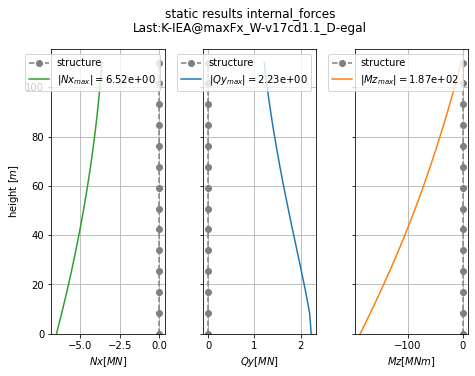

12-Eck 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 609.84
     Gesamt Gewichtskraft am Fuß [MN]: -2.75
     Frequenzen [Hz]: [0.369, 3.048, 6.367]
     Maximales Moment [MNm]: 196.01
     Maximales Moment ohne Kopflast [MNm]: 67.31


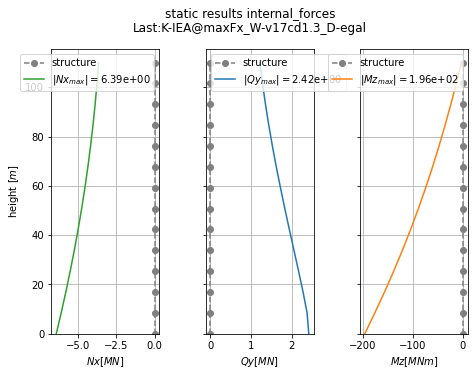

10-Eck 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 597.42
     Gesamt Gewichtskraft am Fuß [MN]: -2.7
     Frequenzen [Hz]: [0.362, 3.016, 6.311]
     Maximales Moment [MNm]: 205.46
     Maximales Moment ohne Kopflast [MNm]: 76.76


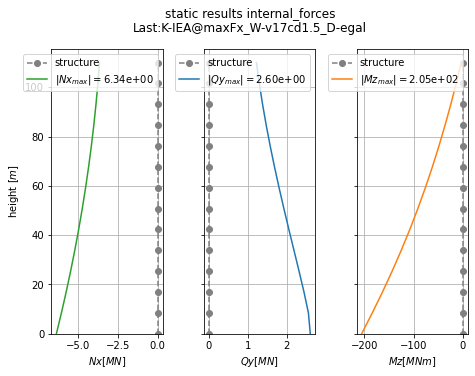

8-Eck 110.0 m
     Gesamt Volumen des Querschnitts [m³]: 574.96
     Gesamt Gewichtskraft am Fuß [MN]: -2.59
     Frequenzen [Hz]: [0.349, 2.958, 6.208]
     Maximales Moment [MNm]: 214.9
     Maximales Moment ohne Kopflast [MNm]: 86.2


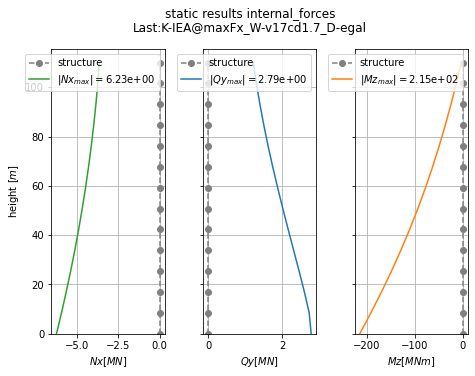

Ring 130.0 m
     Gesamt Volumen des Querschnitts [m³]: 754.74
     Gesamt Gewichtskraft am Fuß [MN]: -3.41
     Frequenzen [Hz]: [0.297, 2.25, 5.89]
     Maximales Moment [MNm]: 220.03
     Maximales Moment ohne Kopflast [MNm]: 67.93
12-Eck 130.0 m
     Gesamt Volumen des Querschnitts [m³]: 720.72
     Gesamt Gewichtskraft am Fuß [MN]: -3.25
     Frequenzen [Hz]: [0.285, 2.196, 5.779]
     Maximales Moment [MNm]: 231.18
     Maximales Moment ohne Kopflast [MNm]: 79.08
10-Eck 130.0 m
     Gesamt Volumen des Querschnitts [m³]: 706.05
     Gesamt Gewichtskraft am Fuß [MN]: -3.19
     Frequenzen [Hz]: [0.279, 2.173, 5.73]
     Maximales Moment [MNm]: 242.35
     Maximales Moment ohne Kopflast [MNm]: 90.25
8-Eck 130.0 m
     Gesamt Volumen des Querschnitts [m³]: 679.5
     Gesamt Gewichtskraft am Fuß [MN]: -3.07
     Frequenzen [Hz]: [0.27, 2.131, 5.639]
     Maximales Moment [MNm]: 253.5
     Maximales Moment ohne Kopflast [MNm]: 101.4
Ring 140.0 m
     Gesamt Volumen des Querschnitts [m³

In [8]:
schnittgrößen = {}
for querschnitt in querschnitte:
    QS_label = querschnitt.name
    nabenhöhe = querschnitt.max_height

    if QS_label not in schnittgrößen:
        schnittgrößen[QS_label] = {}
    if nabenhöhe not in schnittgrößen[QS_label]:
        schnittgrößen[QS_label][nabenhöhe] = {}

    section_properties = querschnitt.section_parameters #os_join(*['inputs', 'geometry', querschnitts_name])

    parameters = utils.add_model_data_from_dict(section_properties, parameters, set_I_eff=False)

    beam = BeamModel(parameters, adjust_mass_density_for_total = False, optimize_frequencies_init=False , apply_k_geo=False)

    print (QS_label, nabenhöhe, 'm')
    print('     Gesamt Volumen des Querschnitts [m³]:', round(beam.volume,2))
    print ('     Gesamt Gewichtskraft am Fuß [MN]:',round(sum(beam.eigengewicht * GD.UNIT_SCALE['MN']),2))

    print ('     Frequenzen [Hz]:', [round(beam.eigenfrequencies[i],3) for i in range(3)])

    gamma_Q = 1.0 # Da lasten schon mit sichterheitsbeiwerte vorliegen (TODO außer windeinwirkung)

    lasten_nach_dauer = {'ständig':{'eigengewicht':True, 'imperfektion':True},
                         'egal':{'eigengewicht':True, 'imperfektion':True},
                         'kurz':{'eigengewicht':False, 'imperfektion':False}}
    for dauer in einwirkungsdauer:
        lasten_file = lasten_files[QS_label][nabenhöhe][dauer]
        lasten_label = os.path.splitext(os.path.basename(lasten_file))[0]
        schnittgrößen[QS_label][nabenhöhe][dauer] = beam.static_analysis_solve(load_vector_file=lasten_file, return_result=True,
                                                                    add_eigengewicht=lasten_nach_dauer[dauer]['eigengewicht'], 
                                                                    add_imperfektion = lasten_nach_dauer[dauer]['imperfektion'])

    print ('     Maximales Moment [MNm]:', round(max(abs(schnittgrößen[QS_label][nabenhöhe]['egal']['g'])) * utils.unit_conversion('Nm', 'MNm'),2))   
    print ('     Maximales Moment ohne Kopflast [MNm]:', round((max(abs(schnittgrößen[QS_label][nabenhöhe]['egal']['g'])) - kopf_lasten_IEA['Fx']*nabenhöhe) * utils.unit_conversion('Nm', 'MNm'),2))   
                                                                 
    if nabenhöhe == 110.0:
        postprocess.plot_static_result_forces(beam, 'internal_forces', ['x','y','g'], unit='MN', title_suffix='Last:' + lasten_label, figsize_scale = 1.1)

    

    #results_df['Mz ' + QS_label_kurz + ' [MNm]'] = SGR_wind_kopf['g'] * utils.unit_conversion('Nm', 'MNm')
    #results_df['Qy ' + QS_label_kurz + ' [MN]'] = SGR_wind_kopf['y'] * utils.unit_conversion('N', 'MN')
    #results_df['Nx ' + QS_label_kurz + ' [MN]'] = SGR_wind_kopf['x'] * utils.unit_conversion('N', 'MN')



# Berechnung der Spannungen

- Für die Liste an Querschnitten werden mit den Entsprechenden Schnittgrößen die Spannungen berechnet
- Bisher nur Normalspannugen infolge Biegung und Normalkraft
- Ausnutzung aufgrund der Druckspannungen aus Moment, Imperfektion und Normalkraft 
- Druckspannung infolge Vorspannkraft wird in einer ersten Annährung durch die Zugspannung abgedeckt

In [9]:
max_ausnutzung = {}
for querschnitt in querschnitte:
  QS_label = querschnitt.name
  nabenhöhe = querschnitt.max_height
  t = round(querschnitt.wand_stärke * 100) # cm
  tX = querschnitt.t_laengslagen * 100
  tY = querschnitt.t_querlagen * 100
  #print ('Spannungs Berechnung für', QS_label)
  if QS_label not in max_ausnutzung:
    max_ausnutzung[QS_label] = {}
    
  last = utils.parse_schnittgrößen_labels(schnittgrößen[QS_label][nabenhöhe])

  querschnitt.calculate_ausnutzung_normalspannung(last, add_vorspannkraft=True)
  # NOTE results_df.loc[:, (Level1, Level2, Level3)] = daten
  results_df.loc[:,(nabenhöhe, QS_label, 'Höhe [' + qs.einheiten['Länge'] + ']')] = querschnitt.section_absolute_heights

  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_zug [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_zug_design
  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_druck [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_druck_design
  results_df.loc[:,(nabenhöhe, QS_label, 'Ausnutzung druck')] = querschnitt.ausnutzung_druck
  max_eta = max(querschnitt.ausnutzung_druck)
  max_ausnutzung[QS_label][str(nabenhöhe) + ' m'] = max_eta
  
  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_N [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_N_design
  results_df.loc[:,(nabenhöhe, QS_label, GD.GREEK_UNICODE['sigma'] + '_M [' + querschnitt.einheiten['Normalspannung'] + ']')] = querschnitt.sigma_M_design
  

max_results_df = pd.DataFrame(max_ausnutzung)
print ('Maximale Ausnutzungen')
print (max_results_df)

#______________________ ALLES IN EXCEL SPEICHERN _________________________________________________________________________________________
d_rows = grund_parameter_df.shape[0] + 7 + results_df.shape[0]
start_row_ti = {48:0, 56:d_rows, 64:2*d_rows}
start_row_max_ti = {48:1, 56:1+8, 64:1+16}

with pd.ExcelWriter(results_excel, mode= 'a', engine="openpyxl", if_sheet_exists='overlay') as writer:#
  nrows = start_row_ti[int(t)] + grund_parameter_df.shape[0]
  results_df.to_excel(writer, sheet_name= 'Berechnungs_Ergebnisse', startrow=nrows+2, startcol=0, index=True, float_format='%.4f')
  grund_parameter_df.to_excel(writer, sheet_name= 'Berechnungs_Ergebnisse', startrow=start_row_ti[int(t)], startcol=0, index=False)

  max_results_df.to_excel(writer, sheet_name= 'Ausnutzungen_max', startrow=start_row_max_ti[t], index=True)

utils.zellen_groeße_formatieren(results_excel, worksheet= 'Berechnungs_Ergebnisse', cell_width=18, n_cols=len(results_df.columns)+1)
utils.zellen_groeße_formatieren(results_excel, worksheet= 'Ausnutzungen_max', cell_width=20, n_cols=len(max_results_df.columns)+1)
utils.zelle_beschriften(results_excel, 'Ausnutzungen_max', 'B' + str(start_row_max_ti[t]), 
                       't, tX, tY [cm] ' + ', '.join([str(int(t)), str(tX), str(tY)]) ,'B' + str(start_row_max_ti[t])+ ':E'+ str(start_row_max_ti[t]))

print ('Ergebnisse in ', results_excel, 'geschrieben')

    

Maximale Ausnutzungen
             Ring    12-Eck    10-Eck     8-Eck
110.0 m  0.938397  1.056297  1.134208  1.269872
130.0 m  1.103111  1.242628  1.335895  1.497791
140.0 m  1.185518  1.336000  1.437085  1.611855
150.0 m  1.267957  1.429413  1.538329  1.726080
160.0 m  1.350429  1.522867  1.639628  1.840497
Ergebnisse in  output\Berechnungs_Ergebnisse.xlsx geschrieben
